In [55]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology
import os
import pandas as pd

In [21]:
def load_mask(path):
    '''Load and process the mask'''
    GT = io.imread(path) + 1
    GT[GT != 1] = 0
    GT = GT.astype(np.bool)
    return GT

def compute_iou(mask, GT):
    '''Computes IoU'''
    intersection = np.logical_and(mask, GT)
    union = np.logical_or(mask, GT)
    return np.sum(intersection) / np.sum(union)

def split_array(array, size=[3,3]):
    d, h, w = array.shape
    arrays = []
    for y in range(size[0]):
        for x in range(size[1]):
            arrays.append(array[:,
                                y*h//size[0]:(y+1)*h//size[0],
                                x*w//size[1]:(x+1)*w//size[1]])

    return arrays



In [27]:
GT = load_mask('features/GroundTruth.tif')
print(GT.shape)
GT_segments = split_array(GT)

(67, 101, 88)


In [109]:
df = pd.DataFrame(columns = ['Feature', 'iou', 'error'])
df2 = pd.DataFrame()
i = 0
for file in os.listdir('features'):
    if file.endswith('.tif'):# and '2' not in file and '3' not in file:
        # if '3' not in file and '2' not in file and 'Trainable' not in file:
        if 'Trainable' not in file:
            i += 1
            mask = load_mask('features/' + file)
            segments = split_array(mask)
            ious = np.zeros(9)
            for j, (segment, GT_segment) in enumerate(zip(segments, GT_segments)):
                ious[j] = compute_iou(segment, GT_segment)

            iou = np.average(ious)
            iou_var = np.var(ious)
            name = file.split('.')[0]
            df.loc[i, 'Feature'] = name
            df.loc[i, 'iou'] = iou
            df.loc[i, 'error'] = iou_var
            for j, IOU in enumerate(ious):
                df2.loc[j, name] = IOU

df = df.sort_values('iou', ascending=True)
df

,Feature,iou,error
8,Derivatives,0.395176,0.006251
1,Gaussian blur,0.476785,0.060966
4,Edges,0.520982,0.007007
2,Hessian,0.546988,0.018027
6,DoG,0.585677,0.008577
3,MaxMinMed,0.625457,0.009930
9,MeanVariance,0.632903,0.008402
10,Laplacian,0.637495,0.007423
5,2last,0.671296,0.011560
11,3second,0.736955,0.010139


<Figure size 720x720 with 0 Axes>

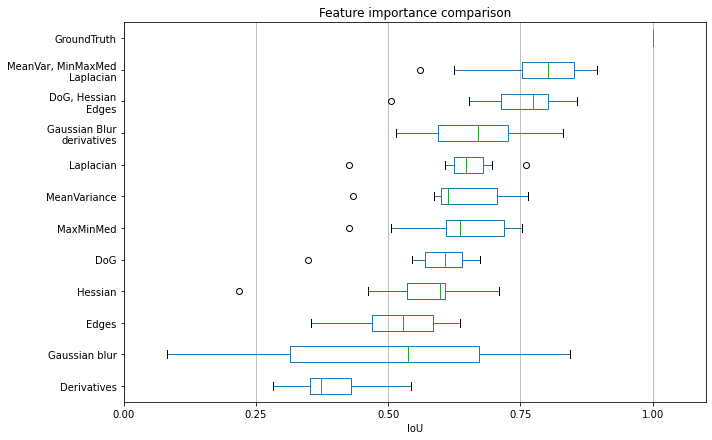

In [129]:
plt.figure(figsize=(10,10))
df2_plot = df2[df.Feature]
df2_plot.rename(columns= {  '3first':'MeanVar, MinMaxMed\nLaplacian',
                            '3second':'DoG, Hessian\nEdges',
                            '2last':'Gaussian Blur\nderivatives'}, inplace=True)
boxplot = df2_plot.plot.box(vert=False, figsize=(10,6))
plt.xlim([0,1.1])
plt.xlabel('IoU')
plt.xticks([0,0.25,0.5,0.75,1])
plt.grid(axis='x')
plt.tight_layout()
plt.title('Feature importance comparison')
plt.savefig('Feature_Comparison_stat.pdf')




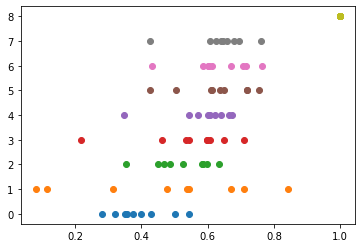

In [105]:
for i, col in enumerate(df2_plot.columns):
    plt.scatter(df2_plot[col], np.ones(len(df2_plot[col]))*i)